Aula 05:

## Criando a conexão com o banco de dados:

In [134]:
import psycopg
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Conectar ao banco de dados PostgreSQL
conn = psycopg.connect("dbname=postgres user=postgres password=password host=172.25.224.1 port=5432")
cursor = conn.cursor()

# Resolução dos exercícios:

## 01.Qual foi o total de receitas no ano de 1997?

In [34]:
query01 = ''' 
-- 01.Qual foi o total de receitas no ano de 1997?
--query 01
SELECT
	SUM(
		(OD.QUANTITY * OD.UNIT_PRICE) * (1.0 - OD.DISCOUNT)
	) AS TOTALREVENUE
FROM
	ORDER_DETAILS AS OD
	JOIN ORDERS AS O ON OD.ORDER_ID = O.ORDER_ID
WHERE
	EXTRACT(
		YEAR
		FROM
			O.ORDER_DATE
	) = 1997;
''' 
pd.read_sql(query01, conn)

,totalrevenue
0,617085.202393


In [36]:
query02 = '''
-- outra forma de obter o mesmo resultado
SELECT
	SUM(
		(OD.QUANTITY * OD.UNIT_PRICE) * (1.0 - OD.DISCOUNT)
	) TOTAL
FROM
	ORDER_DETAILS AS OD
	INNER JOIN (
		SELECT
			ORDER_ID
		FROM
			ORDERS
		WHERE
			EXTRACT(
				YEAR
				FROM
					ORDER_DATE
			) = '1997'
	) AS O ON O.ORDER_ID = OD.ORDER_ID;
'''
pd.read_sql(query02, conn)

,total
0,617085.202393


* **Ambas as queries foram projetadas para calcular o total de receitas no ano de 1997 a partir das tabelas ORDER_DETAILS e ORDERS no banco de dados Northwind. Embora os resultados sejam os mesmos, a maneira como elas alcançam esse resultado é ligeiramente diferente. Vamos explorar as diferenças em detalhes.**

* Quando se trabalha com grandes volumes de dados e especialmente com tabelas que contêm muitos anos de registros, a estratégia de aplicar o filtro antes do join pode ser mais performática. Isso se deve ao fato de que a quantidade de dados a ser processada no join é significativamente reduzida, o que pode melhorar a eficiência geral da consulta. Vamos detalhar isso mais claramente.

### Diferença de Performance

#### Query 01

- **Subconsulta**: A subconsulta filtra a tabela `ORDERS` para incluir apenas os pedidos do ano de 1997. 
  ```sql
  SELECT ORDER_ID FROM ORDERS WHERE EXTRACT(YEAR FROM ORDER_DATE) = '1997'
  ```
- **JOIN**: O join é então realizado apenas com os resultados filtrados, que são significativamente menores do que a tabela completa.
  ```sql
  INNER JOIN (subconsulta filtrada) AS O ON O.ORDER_ID = OD.ORDER_ID
  ```

Neste caso, o otimizador de consultas do PostgreSQL pode aproveitar o fato de que a subconsulta reduz a quantidade de dados antes de realizar o join, o que pode resultar em menos processamento e I/O.

#### Query 02

- **JOIN**: Realiza um join completo entre `ORDER_DETAILS` e `ORDERS` sem nenhum filtro aplicado ainda.
  ```sql
  JOIN ORDERS AS O ON OD.ORDER_ID = O.ORDER_ID
  ```
- **Filtro**: Depois do join, aplica o filtro para o ano de 1997.
  ```sql
  WHERE EXTRACT(YEAR FROM O.ORDER_DATE) = 1997
  ```

Aqui, o join é realizado com a tabela `ORDERS` completa, o que pode ser menos eficiente se a tabela for muito grande e contiver muitos anos de dados. Só depois do join o filtro é aplicado, o que pode resultar em processamento desnecessário de muitos dados que serão descartados posteriormente.

### Resumo

Para grandes volumes de dados com muitos anos distintos, **aplicar o filtro antes do join** (como na Query 01) pode ser mais performático, pois reduz a quantidade de dados processados durante o join. Esta abordagem é geralmente recomendada para melhorar a eficiência das consultas em cenários com grandes volumes de dados.


* **Algumas melhorias :**
* [x] Utilizar CTE(common table expression) para melhorar a legibilidade
* [x] Utilize índices para acelerar as consultas;


##### Uma CTE é como uma "mini-tabela" temporária que você pode criar dentro de uma consulta para facilitar o entendimento e a organização do seu trabalho. Você pode usá-la para dividir a consulta em partes menores e mais manejáveis. 

In [32]:
# Criando indices para acelerar as consultas:
create_index = '''
CREATE INDEX idx_order_date ON orders(order_date);
CREATE INDEX idx_order_id ON order_details(order_id);
'''
cursor.execute(create_index)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe44e841850>

In [33]:
# -- Utilizar CTE(common table expression) para melhorar a legibilidade
query = '''
-- CTE
WITH
	FILTEREDORDERS AS (
		SELECT
			ORDER_ID
		FROM
			ORDERS
		WHERE
			EXTRACT(
				YEAR
				FROM
					ORDER_DATE
			) = 1997
	)

SELECT
	SUM(
		(OD.QUANTITY * OD.UNIT_PRICE) * (1.0 - OD.DISCOUNT)
	) AS Total
FROM
	ORDER_DETAILS AS OD
	inner join FILTEREDORDERS as FO on od.order_id = FO.order_id;
'''
pd.read_sql(query, conn)

,total
0,617085.202393


#### Estrutura da Query

A query é composta de duas partes principais:
1. **Criação de Índices**: Para garantir a eficiência dos filtros e joins.
2. **Consulta Principal com CTE (Common Table Expression)**: Para filtrar os pedidos de 1997 e calcular a receita total.

#### Parte 1: Criação de Índices

Antes de executar a consulta principal, índices são criados nas colunas `order_date` da tabela `orders` e `order_id` da tabela `order_details` para melhorar a performance das operações de filtro e join.

```sql
CREATE INDEX idx_order_date ON orders(order_date);
CREATE INDEX idx_order_id ON order_details(order_id);
```

**Descrição**:
- `idx_order_date`: Índice na coluna `order_date` da tabela `orders`. Esse índice acelera a operação de filtro ao extrair o ano dos pedidos.
- `idx_order_id`: Índice na coluna `order_id` da tabela `order_details`. Esse índice acelera a operação de join entre `orders` e `order_details`.

#### Parte 2: Consulta Principal com CTE

A consulta principal utiliza uma CTE (Common Table Expression) para filtrar os pedidos do ano de 1997 e, em seguida, calcula a receita total desses pedidos.

**Descrição**:

1. **Common Table Expression (CTE)**: `FILTEREDORDERS`
    - **Propósito**: Pré-filtrar os pedidos do ano de 1997.
    - **Estrutura**:
      ```sql
      WITH
          FILTEREDORDERS AS (
              SELECT
                  ORDER_ID
              FROM
                  ORDERS
              WHERE
                  EXTRACT(
                      YEAR
                      FROM
                          ORDER_DATE
                  ) = 1997
          )
      ```
    - **Detalhes**:
        - A CTE `FILTEREDORDERS` seleciona os `ORDER_ID`s da tabela `ORDERS` onde o ano da data do pedido (`ORDER_DATE`) é 1997, utilizando a função `EXTRACT(YEAR FROM ORDER_DATE)`.

2. **Consulta Principal**
    - **Propósito**: Calcular a receita total dos pedidos de 1997.
    - **Estrutura**:
      ```sql
      SELECT
          SUM(
              (OD.QUANTITY * OD.UNIT_PRICE) * (1.0 - OD.DISCOUNT)
          ) AS Total
      FROM
          ORDER_DETAILS AS OD
          INNER JOIN FILTEREDORDERS AS FO ON OD.ORDER_ID = FO.ORDER_ID;
      ```
    - **Detalhes**:
        - **JOIN**: Realiza um `INNER JOIN` entre `ORDER_DETAILS` (alias `OD`) e `FILTEREDORDERS` (alias `FO`) com base na coluna `ORDER_ID`.
        - **Cálculo da Receita Total**: Calcula a receita total multiplicando a quantidade (`QUANTITY`) pelo preço unitário (`UNIT_PRICE`) e ajustando pelo desconto (`DISCOUNT`), usando a expressão `(OD.QUANTITY * OD.UNIT_PRICE) * (1.0 - OD.DISCOUNT)`.
        - **Agregação**: Utiliza a função `SUM` para somar os valores calculados, resultando na receita total dos pedidos de 1997.

#### Considerações sobre Performance

- **Índices**: Os índices criados nas colunas `order_date` e `order_id` são cruciais para a performance. Eles permitem que o banco de dados filtre e junte os dados de forma eficiente.
- **Filtragem antes do Join**: Utilizar a CTE para filtrar os pedidos antes de realizar o join reduz significativamente a quantidade de dados processados durante o join, melhorando a eficiência da consulta.


#### Conclusão
A CTE é uma ferramenta poderosa para escrever consultas SQL mais claras e eficientes, mas sua natureza é temporária. Se a persistência dos resultados intermediários for necessária, considere usar tabelas temporárias ou views.

* Como remover o index criado:

In [31]:
remover_index = '''
-- Remover o índice em order_date da tabela orders
-- Remover o índice em order_id da tabela order_details
DROP INDEX IF EXISTS idx_order_date;
DROP INDEX IF EXISTS idx_order_id;
'''
cursor.execute(remover_index)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe44e841850>

In [38]:
# Fecha o cursor e a conexão
cursor.close()
conn.close()

## 02.Faça uma análise de crescimento mensal e o cálculo de YTD

In [42]:
create_index = '''
-- Certifique-se de que há índices adequados nas colunas usadas para junções e filtros
CREATE INDEX IF NOT EXISTS idx_orders_order_date ON orders(order_date);
CREATE INDEX IF NOT EXISTS idx_order_details_order_id ON order_details(order_id);
''' 
cursor.execute(create_index)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe44faa4bf0>

In [74]:
query = ''' 
-- 02.Faça uma análise de crescimento mensal e o cálculo de YTD
WITH ReceitasMensais AS (
    SELECT
        EXTRACT(YEAR FROM orders.order_date) AS year,
        EXTRACT(MONTH FROM orders.order_date) AS month,
        SUM(order_details.unit_price * order_details.quantity * (1.0 - order_details.discount)) AS Receita_Mensal
    FROM
        orders
    INNER JOIN
        order_details ON orders.order_id = order_details.order_id
    GROUP BY
        EXTRACT(YEAR FROM orders.order_date),
        EXTRACT(MONTH FROM orders.order_date)
),
ReceitasAcumuladas AS (
    SELECT
        year,
        month,
        Receita_Mensal,
        SUM(Receita_Mensal) OVER (PARTITION BY year ORDER BY month) AS Receita_YTD
    FROM
        ReceitasMensais
)
SELECT
    year,
    month,
    Receita_Mensal,
    Receita_Mensal - LAG(Receita_Mensal) OVER (PARTITION BY year ORDER BY month) AS Diferenca_Mensal,
    Receita_YTD,
	(Receita_Mensal - LAG(Receita_Mensal) OVER (PARTITION BY year ORDER BY month))
	/ LAG(Receita_Mensal) OVER (PARTITION BY year ORDER BY month) * 100 AS Percentual_Mudanca_Mensal
FROM
    ReceitasAcumuladas
ORDER BY
    year, month;
''' 
receita = pd.read_sql(query, conn)

In [75]:
receita.head()

,year,month,receita_mensal,diferenca_mensal,receita_ytd,percentual_mudanca_mensal
0,1996.0,7.0,27861.895130,NaN,27861.895130,NaN
1,1996.0,8.0,25485.275071,-2376.620059,53347.170200,-8.530001
2,1996.0,9.0,26381.400133,896.125062,79728.570333,3.516246
3,1996.0,10.0,37515.724945,11134.324813,117244.295278,42.205208
4,1996.0,11.0,45600.045211,8084.320266,162844.340490,21.549151


#### Descrição Geral
Esta query SQL calcula e analisa as receitas mensais e acumuladas de pedidos em uma base de dados, fornecendo informações sobre a receita de cada mês, a diferença de receita em relação ao mês anterior, a receita acumulada (Year-to-Date, YTD) e a porcentagem de mudança mensal. A query utiliza duas Expressões Comuns de Tabela (CTEs) para organizar e processar os dados.

#### Estrutura da Query
A query é composta de duas CTEs (Common Table Expressions) e uma instrução `SELECT` final que combina e processa os resultados das CTEs.

#### Detalhamento das CTEs

1. **CTE: ReceitasMensais**
    - **Propósito**: Calcular a receita total para cada mês e ano.
    - **Colunas**:
        - `Ano`: Ano extraído da data do pedido (`order_date`).
        - `Mes`: Mês extraído da data do pedido (`order_date`).
        - `Receita_Mensal`: Receita total do mês, calculada como o somatório do produto do preço unitário (`unit_price`), quantidade (`quantity`) e desconto (`discount`).
    
2. **CTE: ReceitasAcumuladas**
    - **Propósito**: Calcular a receita acumulada (YTD) para cada mês dentro de um ano.
    - **Colunas**:
        - `Ano`: Ano da receita.
        - `Mes`: Mês da receita.
        - `Receita_Mensal`: Receita total do mês.
        - `Receita_YTD`: Receita acumulada do início do ano até o mês atual, calculada usando a função de janela `SUM` com particionamento por ano e ordenação por mês.
    
#### Instrução Final `SELECT`
- **Propósito**: Combinar os resultados das CTEs para fornecer informações detalhadas sobre a receita mensal e acumulada.
- **Colunas**:
    - `Ano`: Ano da receita.
    - `Mes`: Mês da receita.
    - `Receita_Mensal`: Receita total do mês.
    - `Diferenca_Mensal`: Diferença na receita em relação ao mês anterior, calculada como a diferença entre a receita do mês atual e a receita do mês anterior usando a função `LAG`.
    - `Receita_YTD`: Receita acumulada do início do ano até o mês atual.
    - `Percentual_Mudanca_Mensal`: Percentual de mudança na receita em relação ao mês anterior, calculado como a diferença mensal dividida pela receita do mês anterior, multiplicada por 100.

#### Explicação dos Elementos Chave

1. **EXTRACT(YEAR FROM orders.order_date) AS Ano, EXTRACT(MONTH FROM orders.order_date) AS Mes**:
    - Extrai o ano e o mês da data do pedido (`order_date`).

2. **SUM(order_details.unit_price * order_details.quantity * (1.0 - order_details.discount)) AS Receita_Mensal**:
    - Calcula a receita mensal somando o valor total de cada item do pedido, considerando o preço unitário, a quantidade e o desconto.

3. **INNER JOIN orders.order_id = order_details.order_id**:
    - Junta as tabelas `orders` e `order_details` para associar os detalhes dos pedidos às suas respectivas ordens.

4. **SUM(Receita_Mensal) OVER (PARTITION BY Ano ORDER BY Mes) AS Receita_YTD**:
    - Calcula a receita acumulada (YTD) para cada mês dentro de um ano.

5. **LAG(Receita_Mensal) OVER (PARTITION BY Ano ORDER BY Mes)**:
    - Função de janela que retorna a receita do mês anterior, usada para calcular a diferença mensal e a mudança percentual.

6. **ORDER BY Ano, Mes**:
    - Ordena os resultados finais por ano e mês.

#### Finalidade e Utilização
- **Análise Financeira**: Esta query é útil para analistas financeiros e gerentes de vendas que desejam acompanhar o desempenho mensal das receitas e entender as tendências de crescimento.
- **Tomada de Decisões**: Fornece informações valiosas para a tomada de decisões estratégicas, identificando padrões de crescimento e possíveis áreas de melhoria.
- **Relatórios**: Pode ser utilizada em relatórios financeiros para demonstrar o desempenho mensal e acumulado das receitas.

## Vamos analisar os resultados e aproveitar o poder do python para criar alguns graficos:

In [76]:
#informação do dataset
receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       23 non-null     float64
 1   month                      23 non-null     float64
 2   receita_mensal             23 non-null     float64
 3   diferenca_mensal           20 non-null     float64
 4   receita_ytd                23 non-null     float64
 5   percentual_mudanca_mensal  20 non-null     float64
dtypes: float64(6)
memory usage: 1.2 KB


In [77]:
# Converter a coluna 'ano' e 'mes' de float para int
receita[['year', 'month']] = receita[['year', 'month']].astype(int)

In [78]:
# Criar uma nova coluna para dia, levando em consideração apenas o dia primeiro de cada mês para o exemplo.
receita['day'] = 1

In [79]:
# Converter ano e mês em uma única coluna de data para facilitar a plotagem
receita['data'] = pd.to_datetime(receita[['year', 'month','day']])

In [80]:
receita.head()

,year,month,receita_mensal,diferenca_mensal,receita_ytd,percentual_mudanca_mensal,day,data
0,1996,7,27861.895130,NaN,27861.895130,NaN,1,1996-07-01
1,1996,8,25485.275071,-2376.620059,53347.170200,-8.530001,1,1996-08-01
2,1996,9,26381.400133,896.125062,79728.570333,3.516246,1,1996-09-01
3,1996,10,37515.724945,11134.324813,117244.295278,42.205208,1,1996-10-01
4,1996,11,45600.045211,8084.320266,162844.340490,21.549151,1,1996-11-01


In [82]:
#intalação da lib matplotlib para plotagem de gráficos 
!poetry add matplotlib -q

In [86]:
#importação da lib 
import matplotlib.pyplot as plt 

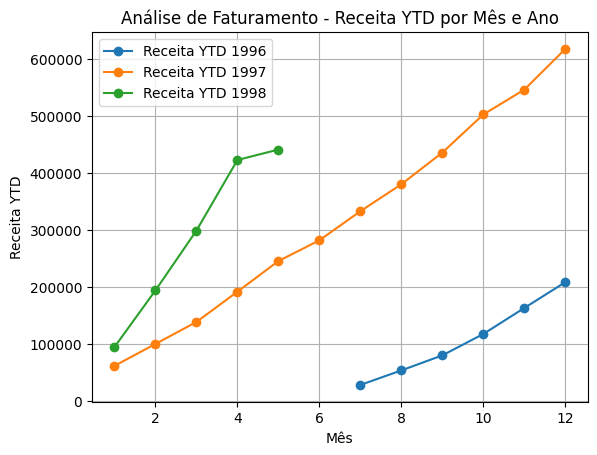

In [90]:
# Plotar Receita YTD para cada ano
years = receita['year'].unique()
for year in years:
    yearly_data = receita[receita['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['receita_ytd'], marker='o', linestyle='-', label=f'Receita YTD {year}')

# Adicionar Título e Rótulos
plt.title('Análise de Faturamento - Receita YTD por Mês e Ano')
plt.xlabel('Mês')
plt.ylabel('Receita YTD')
plt.grid(True)
plt.legend()

# Exibir o Gráfico
plt.show()

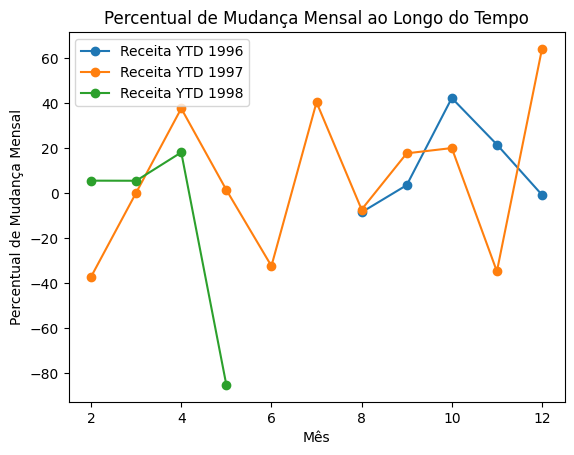

In [92]:
# Plotar Receita YTD para cada ano
years = receita['year'].unique()
for year in years:
    yearly_data = receita[receita['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['percentual_mudanca_mensal'], marker='o', linestyle='-', label=f'Receita YTD {year}')

# Adicionar Título e Rótulos
plt.title('Percentual de Mudança Mensal ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Percentual de Mudança Mensal')
plt.grid(False)
plt.legend()

# Exibir o Gráfico
plt.show()

## 03.Calcular o valor total que cada cliente pagou até agora, listando os clientes por ordem decrescente de valor total pago?

In [101]:
query = ''' 
-- 03.Calcular o valor total que cada cliente pagou até agora, listando os clientes por ordem decrescente de valor total pago.
CREATE VIEW view_total_revenues_per_customer AS
WITH CustomerOrders AS (
    SELECT 
        c.company_name, 
        od.unit_price, 
        od.quantity, 
        od.discount
    FROM 
        customers c
    INNER JOIN 
        orders o ON c.customer_id = o.customer_id
    INNER JOIN 
        order_details od ON od.order_id = o.order_id
)
SELECT 
    company_name, 
    SUM(unit_price * quantity * (1.0 - discount)) AS total
FROM 
    CustomerOrders
GROUP BY 
    company_name
ORDER BY 
    total DESC;
'''
cursor.execute(query)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe441ad0f60>

In [102]:
df = pd.read_sql("select * from view_total_revenues_per_customer", conn)
df.head()

,company_name,total
0,QUICK-Stop,110277.305030
1,Ernst Handel,104874.978144
2,Save-a-lot Markets,104361.949540
3,Rattlesnake Canyon Grocery,51097.800828
4,Hungry Owl All-Night Grocers,49979.905081


#### Estrutura da Query:

1. **Criação da View**:
   - A view é criada com o nome `view_total_revenues_per_customer`.

2. **Seleção da CTE**:
   - Seleciona `company_name`, `unit_price`, `quantity` e `discount` das tabelas associadas.

3. **Consulta Principal**:
   - A consulta principal seleciona `company_name` e calcula a soma total dos valores pagos por cada cliente.

4. **Agrupamento e Ordenação**:
   - `GROUP BY company_name`: Agrupa os resultados pelo nome da empresa cliente.
   - `ORDER BY total DESC`: Ordena os resultados pelo valor total em ordem decrescente.

### Conclusão:

A query usa uma CTE para melhorar a legibilidade e estrutura da consulta. A criação da view `view_total_revenues_per_customer` permite que os usuários consultem facilmente o valor total pago por cada cliente até o momento.

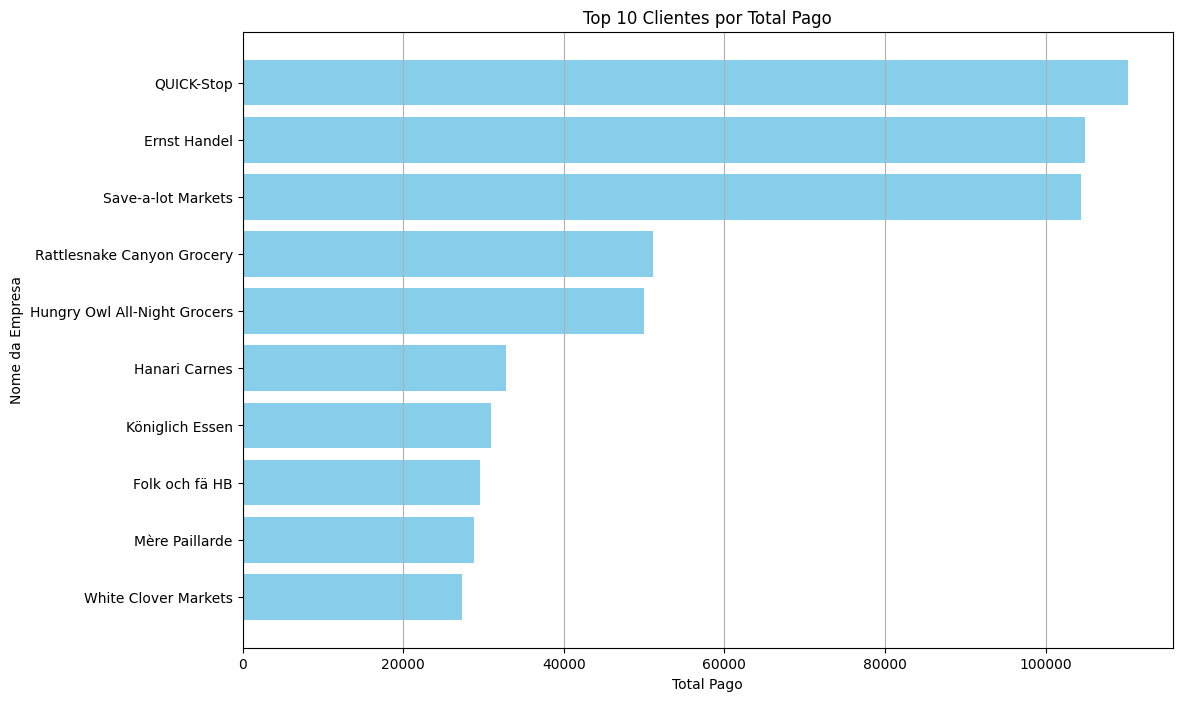

In [104]:
# Configurar o plot
plt.figure(figsize=(12, 8))
#selecionando os 10 primeiros
df_10 = df.head(10)
# Plotar o gráfico de barras
plt.barh(df_10['company_name'], df_10['total'], color='skyblue')
plt.xlabel('Total Pago')
plt.ylabel('Nome da Empresa')
plt.title('Top 10 Clientes por Total Pago')
plt.gca().invert_yaxis()  # Inverter o eixo y para que o maior valor fique no topo
plt.grid(axis='x')

# Exibir o gráfico
plt.show()

## 04.Separe os clientes em 5 grupos de acordo com o valor pago por cliente:

In [112]:
query = ''' 
-- 04.Separe os clientes em 5 grupos de acordo com o valor pago por cliente
CREATE VIEW VIEW_TOTAL_REVENUES_PER_CUSTOMER_GROUP AS
WITH
	CUSTOMERORDERDETAILS AS (
		SELECT
			C.COMPANY_NAME,
			OD.UNIT_PRICE,
			OD.QUANTITY,
			OD.DISCOUNT
		FROM
			CUSTOMERS C
			INNER JOIN ORDERS O ON C.CUSTOMER_ID = O.CUSTOMER_ID
			INNER JOIN ORDER_DETAILS OD ON OD.ORDER_ID = O.ORDER_ID
	),
	REVENUEPERCUSTOMER AS (
		SELECT
			COMPANY_NAME,
			SUM(UNIT_PRICE * QUANTITY * (1.0 - DISCOUNT)) AS TOTAL
		FROM
			CUSTOMERORDERDETAILS
		GROUP BY
			COMPANY_NAME
	)
SELECT
	COMPANY_NAME,
	TOTAL,
	NTILE(5) OVER (
		ORDER BY
			TOTAL DESC
	) AS GROUP_NUMBER
FROM
	REVENUEPERCUSTOMER
ORDER BY
	TOTAL DESC;
'''
cursor.execute(query)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe4907a6980>

In [113]:
df = pd.read_sql("select * from view_total_revenues_per_customer_group",conn) 
df.head()

,company_name,total,group_number
0,QUICK-Stop,110277.305030,1
1,Ernst Handel,104874.978144,1
2,Save-a-lot Markets,104361.949540,1
3,Rattlesnake Canyon Grocery,51097.800828,1
4,Hungry Owl All-Night Grocers,49979.905081,1


### Documentação da View: Agrupamento de Clientes por Valor Pago

#### Objetivo:
A criação desta view tem como finalidade categorizar os clientes em cinco grupos com base no valor total que cada cliente pagou até o momento. Esta categorização facilita a análise e segmentação dos clientes de acordo com suas contribuições financeiras para a empresa.

#### Estrutura da Query:

1. **Criação da View**:
   - A view é criada com o nome `VIEW_TOTAL_REVENUES_PER_CUSTOMER_GROUP`.

2. **Common Table Expressions (CTEs)**:
   - **CUSTOMERORDERDETAILS**:
     - Seleciona dados necessários das tabelas `CUSTOMERS`, `ORDERS` e `ORDER_DETAILS`.
   - **REVENUEPERCUSTOMER**:
     - Calcula o valor total pago por cada cliente.

3. **Consulta Principal**:
   - Seleciona o nome da empresa (`COMPANY_NAME`), o total de receitas (`TOTAL`) e o número do grupo (`GROUP_NUMBER`), utilizando a função `NTILE(5)` para dividir os clientes em cinco grupos com base no valor total pago em ordem decrescente.


### Explicação Detalhada:

1. **Common Table Expression (CTE) `CUSTOMERORDERDETAILS`**:
   - Seleciona os seguintes campos:
     - `COMPANY_NAME`: Nome da empresa cliente.
     - `UNIT_PRICE`: Preço unitário do produto.
     - `QUANTITY`: Quantidade do produto.
     - `DISCOUNT`: Desconto aplicado.
   - As tabelas `CUSTOMERS`, `ORDERS` e `ORDER_DETAILS` são unidas através de `INNER JOIN`:
     - `CUSTOMERS` é unida a `ORDERS` pela chave `CUSTOMER_ID`.
     - `ORDERS` é unida a `ORDER_DETAILS` pela chave `ORDER_ID`.

2. **CTE `REVENUEPERCUSTOMER`**:
   - Agrupa os dados da CTE `CUSTOMERORDERDETAILS` por `COMPANY_NAME`.
   - Calcula a soma total das receitas para cada cliente utilizando a fórmula:
     - `SUM(UNIT_PRICE * QUANTITY * (1.0 - DISCOUNT))`.

3. **Consulta Principal**:
   - Seleciona os seguintes campos:
     - `COMPANY_NAME`: Nome da empresa cliente.
     - `TOTAL`: Soma total do valor pago por cada cliente.
     - `GROUP_NUMBER`: Número do grupo, determinado pela função `NTILE(5)`, que divide os clientes em cinco grupos com base no valor total pago, em ordem decrescente.
   - Ordena os resultados pelo valor total (`TOTAL`) em ordem decrescente.

### Benefícios:

- **Segmentação de Clientes**: A view facilita a segmentação dos clientes com base no valor total pago, permitindo identificar quais clientes são mais valiosos para a empresa.
- **Análise de Receita**: Proporciona uma visão clara das contribuições financeiras dos clientes, possibilitando análises detalhadas de receita.
- **Melhoria na Tomada de Decisões**: A categorização ajuda na criação de estratégias de marketing e vendas específicas para cada grupo de clientes, aprimorando a tomada de decisões.

### Considerações Finais:

A criação da view `VIEW_TOTAL_REVENUES_PER_CUSTOMER_GROUP` é uma prática eficiente para organizar e analisar os dados de receita por cliente. A utilização de Common Table Expressions (CTEs) torna a consulta mais legível e fácil de manter. A função `NTILE(5)` facilita a classificação dos clientes em grupos, permitindo uma análise segmentada e detalhada das receitas geradas.

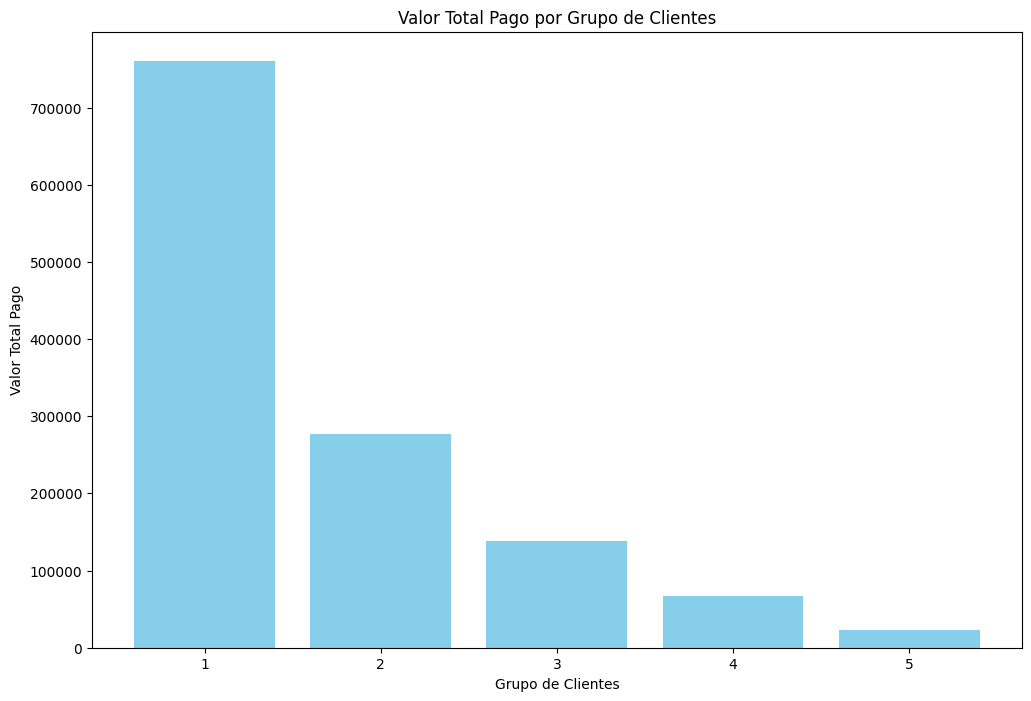

In [122]:
# Configurar o plot
plt.figure(figsize=(12, 8))

# Plotar o gráfico de barras
groups = df.groupby('group_number')['total'].sum().reset_index()

plt.bar(groups['group_number'], groups['total'], color='skyblue')
plt.xlabel('Grupo de Clientes')
plt.ylabel('Valor Total Pago')
plt.title('Valor Total Pago por Grupo de Clientes')
plt.xticks(groups['group_number'])

# Exibir o gráfico
plt.show()

## 05.Selecionar os clientes dos grupos 3, 4 e 5, ordenados pelo valor total pago

In [123]:
query = '''
-- 05.Selecionar os clientes dos grupos 3, 4 e 5, ordenados pelo valor total pago
CREATE VIEW clients_to_marketing AS
WITH cliente_order_details AS (
    SELECT
        c.company_name,
        od.unit_price,
        od.quantity,
        od.discount
    FROM
        customers c
    INNER JOIN orders o ON c.customer_id = o.customer_id
    INNER JOIN order_details od ON od.order_id = o.order_id
),
revenue_per_customer AS (
    SELECT
        company_name,
        SUM(unit_price * quantity * (1.0 - discount)) AS total,
        NTILE(5) OVER (ORDER BY SUM(unit_price * quantity * (1.0 - discount)) DESC) AS group_number
    FROM
        cliente_order_details
    GROUP BY
        company_name
)
SELECT
    company_name,
    total,
    group_number
FROM
    revenue_per_customer
WHERE
    group_number >= 3
ORDER BY
    total DESC;
''' 
cursor.execute(query)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe4907a6980>

In [124]:
df = pd.read_sql("select * from clients_to_marketing", conn) 
df.head()

,company_name,total,group_number
0,Split Rail Beer & Ale,11441.630072,3
1,Tortuga Restaurante,10812.150034,3
2,Maison Dewey,9736.075007,3
3,Die Wandernde Kuh,9588.424963,3
4,La maison d'Asie,9328.200015,3


#### Estrutura da Query
A query utiliza Common Table Expressions (CTEs) para estruturar e organizar a lógica, tornando-a mais legível e eficiente. A view final apresenta os clientes com seus respectivos valores totais pagos e os grupos aos quais pertencem, filtrando para exibir apenas os clientes dos grupos 3, 4 e 5.

#### Descrição Detalhada da Query

1. **Criação da View `clients_to_marketing`**:
   - A view é criada para armazenar os resultados da query.

2. **Common Table Expression (CTE) `cliente_order_details`**:
   - **Objetivo**: Selecionar e unir detalhes de pedidos de clientes das tabelas `customers`, `orders` e `order_details`.
   - **Estrutura**:
     ```sql
     WITH cliente_order_details AS (
         SELECT
             c.company_name,
             od.unit_price,
             od.quantity,
             od.discount
         FROM
             customers c
         INNER JOIN orders o ON c.customer_id = o.customer_id
         INNER JOIN order_details od ON od.order_id = o.order_id
     ),
     ```
     - **Colunas Selecionadas**:
       - `c.company_name`: Nome da empresa cliente.
       - `od.unit_price`: Preço unitário dos produtos.
       - `od.quantity`: Quantidade dos produtos.
       - `od.discount`: Desconto aplicado.

3. **CTE `revenue_per_customer`**:
   - **Objetivo**: Calcular o valor total pago por cada cliente e dividi-los em cinco grupos com base nesse valor.
   - **Estrutura**:
     ```sql
     revenue_per_customer AS (
         SELECT
             company_name,
             SUM(unit_price * quantity * (1.0 - discount)) AS total,
             NTILE(5) OVER (ORDER BY SUM(unit_price * quantity * (1.0 - discount)) DESC) AS group_number
         FROM
             cliente_order_details
         GROUP BY
             company_name
     )
     ```
     - **Colunas Selecionadas**:
       - `company_name`: Nome da empresa cliente.
       - `total`: Soma total do valor pago, calculada como `SUM(unit_price * quantity * (1.0 - discount))`.
       - `group_number`: Número do grupo, de 1 a 5, determinado pela função `NTILE(5)`.

4. **Consulta Principal**:
   - **Objetivo**: Selecionar os clientes dos grupos 3, 4 e 5, ordenados pelo valor total pago.
   - **Estrutura**:
     ```sql
     SELECT
         company_name,
         total,
         group_number
     FROM
         revenue_per_customer
     WHERE
         group_number >= 3
     ORDER BY
         total DESC;
     ```
     - **Filtragem**:
       - `WHERE group_number >= 3`: Inclui apenas os clientes dos grupos 3, 4 e 5.
     - **Ordenação**:
       - `ORDER BY total DESC`: Ordena os clientes pelo valor total pago, em ordem decrescente.

### Resultado Esperado
A view `clients_to_marketing` resultante contém os seguintes campos para os clientes que estão nos grupos 3, 4 e 5:
- `company_name`: Nome da empresa cliente.
- `total`: Valor total pago.
- `group_number`: Número do grupo ao qual o cliente pertence, de 3 a 5.

## 06.Identificar os 10 produtos mais vendidos:

In [128]:
query = ''' 
-- 06. Identificar os 10 produtos mais vendidos:
CREATE VIEW TOP_10_PRODUCTS AS
SELECT
	PRODUCTS.PRODUCT_NAME,
	SUM(
		ORDER_DETAILS.UNIT_PRICE * ORDER_DETAILS.QUANTITY * (1.0 - ORDER_DETAILS.DISCOUNT)
	) AS SALES
FROM
	PRODUCTS
	INNER JOIN ORDER_DETAILS ON ORDER_DETAILS.PRODUCT_ID = PRODUCTS.PRODUCT_ID
GROUP BY
	PRODUCTS.PRODUCT_NAME
ORDER BY SALES DESC;
''' 
cursor.execute(query)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe43f5643b0>

In [131]:
pd.read_sql("select * from TOP_10_PRODUCTS", conn).head(10)

,product_name,sales
0,Côte de Blaye,141396.735627
1,Thüringer Rostbratwurst,80368.672439
2,Raclette Courdavault,71155.699909
3,Tarte au sucre,47234.969979
4,Camembert Pierrot,46825.480295
5,Gnocchi di nonna Alice,42593.059822
6,Manjimup Dried Apples,41819.650246
7,Alice Mutton,32698.380216
8,Carnarvon Tigers,29171.874963
9,Rössle Sauerkraut,25696.639789


## 07. Quais clientes do Reino Unido pagaram mais de 1000 dólares?

In [135]:
query = ''' 
-- 07. Quais clientes do Reino Unido pagaram mais de 1000 dólares?
CREATE VIEW uk_clients_who_pay_more_than_1000 AS
WITH customer_order_details AS (
    SELECT
        c.contact_name,
        od.unit_price,
        od.quantity,
        od.discount
    FROM
        customers c
    INNER JOIN orders o ON c.customer_id = o.customer_id
    INNER JOIN order_details od ON od.order_id = o.order_id
    WHERE LOWER(c.country) = 'uk'
)
SELECT
    contact_name,
    SUM(unit_price * quantity * (1.0 - discount)) AS payments
FROM
    customer_order_details
GROUP BY
    contact_name
HAVING
    SUM(unit_price * quantity * (1.0 - discount)) > 1000;
''' 
cursor.execute(query)

<psycopg.Cursor [COMMAND_OK] [INTRANS] (host=172.25.224.1 database=postgres) at 0x7fe4418e7110>

In [136]:
pd.read_sql("select * from uk_clients_who_pay_more_than_1000", conn).head()

,contact_name,payments
0,Ann Devon,14761.034930
1,Victoria Ashworth,6089.899990
2,Thomas Hardy,13390.649974
3,Hari Kumar,16215.325044
4,Helen Bennett,6146.299985


#### Objetivo
A view `uk_clients_who_pay_more_than_1000` tem como objetivo identificar os clientes localizados no Reino Unido que realizaram pagamentos totais superiores a 1000 dólares.

#### Estrutura da Query
1. **Criação da View**:
   - A view é criada com o nome `uk_clients_who_pay_more_than_1000`.
2. **Common Table Expression (CTE) `customer_order_details`**:
   - Seleciona os detalhes das ordens para clientes do Reino Unido, incluindo o nome do contato, preço unitário dos produtos, quantidade e desconto.
   - Filtra os clientes pelo país, convertendo a entrada para minúsculas para garantir a correspondência correta.
3. **Consulta Principal**:
   - Calcula o valor total pago por cada cliente, agrupando os resultados pelo nome do contato.
   - Filtra os resultados para incluir apenas os clientes cujos pagamentos totais excedem 1000 dólares.

#### Explicação Detalhada:

1. **Common Table Expression (CTE) `customer_order_details`**:
   - Seleciona os detalhes das ordens para clientes do Reino Unido.
   - Filtra os clientes pelo país utilizando `LOWER(c.country) = 'uk'`, convertendo a entrada para minúsculas para garantir correspondência exata.
   
2. **Consulta Principal**:
   - Calcula o valor total pago por cada cliente, somando o preço unitário dos produtos multiplicado pela quantidade e desconto.
   - Agrupa os resultados pelo nome do contato.
   - Utiliza a cláusula `HAVING` para filtrar os resultados e incluir apenas os clientes cujos pagamentos totais superam 1000 dólares.

#### Benefícios da Query:

- **Identificação Precisa**: A query fornece uma lista precisa dos clientes do Reino Unido que pagaram mais de 1000 dólares, facilitando análises financeiras e ações de marketing direcionadas.
- **Eficiência**: O uso de CTEs e a filtragem por país garantem uma execução eficiente da consulta, minimizando o processamento desnecessário de dados.

#### Resultado Esperado
A view `uk_clients_who_pay_more_than_1000` contém os seguintes campos para os clientes do Reino Unido com pagamentos superiores a 1000 dólares:
- `contact_name`: Nome do contato do cliente.
- `payments`: Valor total pago por cada cliente.

#### A análise de dados com SQL é uma habilidade fundamental para profissionais de diversas áreas, permitindo a extração de insights valiosos de grandes conjuntos de dados. Ao dominar conceitos como seleção, filtragem, agregação e análise temporal, além de técnicas avançadas como a criação de gráficos, somos capazes de tomar decisões mais informadas, identificar tendências e padrões, otimizar recursos e aumentar a competitividade no mercado. Com a análise de dados, contribuímos para o sucesso e crescimento das organizações em que atuamos, impulsionando a inovação e a eficácia das estratégias adotadas.